In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
import warnings
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss

import category_encoders as ce
warnings.filterwarnings('ignore')

In [2]:
train_file = "/Users/HaoShaochun/Yam/FinancialRiskControl/data/train.csv"
test_file = "/Users/HaoShaochun/Yam/FinancialRiskControl/data/testA.csv"

**所有特征**

类别数据：

- grade 贷款等级
- subGrade 贷款等级之子级
- employmentLength 就业年限（年）
- issueDate 贷款发放的月份
- earliesCreditLine 借款人最早报告的信用额度开立的月份


数值数据：

- id
- loanAmnt 贷款金额
- interestRate 贷款利率
- installment 分期付款金额
- employmentTitle 就业职称
- annualIncome 年收入
- postCode 借款人在贷款申请中提供的邮政编码的前3位数字
- regionCode 地区编码
- purpose 借款人在贷款申请时的贷款用途类别
- dti 债务收入比
- delinquency_2years 借款人过去2年信用档案中逾期30天以上的违约事件数
- ficoRangeLow 借款人在贷款发放时的fico所属的下限范围
- ficoRangeHigh 借款人在贷款发放时的fico所属的上限范围
- openAcc 借款人信用档案中未结信用额度的数量
- pubRec 贬损公共记录的数量
- pubRecBankruptcies 公开记录清除的数量
- revolBal 信贷周转余额合计
- revolUtil 循环额度利用率，或借款人使用的相对于所有可用循环信贷的信贷金额
- totalAcc 借款人信用档案中当前的信用额度总数
- title 借款人提供的贷款名称
- n 系列：n0 n1 n2 n2.1 n4 n5 n6 n7 n8 n9 n10 n13 n14


- term 贷款期限
- homeOwnership 借款人在登记时提供的房屋所有权状况
- verificationStatus 验证状态
- initialListStatus 贷款的初始列表状态
- applicationType 表明贷款是个人申请还是与两个共同借款人的联合申请
- n 系列：n11 n12

In [3]:
data_train = pd.read_csv(train_file)
data_test = pd.read_csv(test_file)

## 数据预处理

### 删除唯一值

In [4]:
# 删除唯一值的特征
uniq_value_feas = [col for col in data_train.columns if data_train[col].nunique() <= 1]
data_train = data_train.drop(columns=uniq_value_feas)

In [5]:
# 删除每个样本一个唯一值的特征
uniq_feavalue_feas = ["id"]
data_train = data_train.drop(columns=uniq_feavalue_feas)

### 填充缺失值

In [6]:
# 获取缺失值
def get_missing_feas(data):
    missing = data.isnull().sum()
    missing = missing[missing > 0]
    return missing.to_dict()

In [7]:
train_missing = get_missing_feas(data_train)
train_missing

{'employmentTitle': 1,
 'employmentLength': 46799,
 'postCode': 1,
 'dti': 239,
 'pubRecBankruptcies': 405,
 'revolUtil': 531,
 'title': 1,
 'n0': 40270,
 'n1': 40270,
 'n2': 40270,
 'n2.1': 40270,
 'n4': 33239,
 'n5': 40270,
 'n6': 40270,
 'n7': 40270,
 'n8': 40271,
 'n9': 40270,
 'n10': 33239,
 'n11': 69752,
 'n12': 40270,
 'n13': 40270,
 'n14': 40270}

In [8]:
test_missing = get_missing_feas(data_test)
test_missing

{'employmentLength': 11742,
 'dti': 61,
 'pubRecBankruptcies': 116,
 'revolUtil': 127,
 'n0': 10111,
 'n1': 10111,
 'n2': 10111,
 'n2.1': 10111,
 'n2.2': 10111,
 'n2.3': 10111,
 'n4': 8394,
 'n5': 10111,
 'n6': 10111,
 'n7': 10111,
 'n8': 10111,
 'n9': 10111,
 'n10': 8394,
 'n11': 17575,
 'n12': 10111,
 'n13': 10111,
 'n14': 10111}

对比发现，训练集比测试集多了 3 个可以用众数填充的特征，而且就缺少了 1 个样本。

测试集比训练集多了 3 个 n 系列指标，显然这俩指标没啥意义。

众数填充：

- employmentTitle：就业职称
- postCode：借款人在贷款申请中提供的邮政编码的前3位数字
- title：借款人提供的贷款名称

这三个指标都只缺了一个样本，可以考虑直接删掉。

In [9]:
mode_feas = ["employmentTitle", "postCode", "title"]
data_train = data_train.dropna(subset=mode_feas)
data_train = data_train.reset_index(drop=True)

加权平均：

- dti：债务收入比
- revolUtil：循环额度利用率，或借款人使用的相对于所有可用循环信贷的信贷金额

加权平均后取整：

- pubRecBankruptcies：公开记录清除的数量
- n 系列

因为 n 系列虽然是 float 型，但其实都是整数，自然我们也取整数比较好

最纠结的是 employmentLength（就业年限），这个我的理解是取平均值比较好，如果是分桶的话，那就取样本最多的桶。

另外要注意，直接在 DataFrame 上取平均其实是加权平均，也可以直接对唯一值取平均，我们这里统一采用加权平均，即出现次数就是权重。

In [10]:
# data_train.employmentLength.unique()

In [11]:
# 平均
ave_feas = ["dti", "revolUtil"]
data_train[ave_feas] = data_train[ave_feas].fillna(data_train[ave_feas].mean())

In [12]:
# 平均后取整
ave_floor_feas = ["pubRecBankruptcies"] + [f for f in train_missing if f.startswith("n")]
data_train[ave_floor_feas] = data_train[ave_floor_feas].fillna(data_train[ave_floor_feas].mean().apply(int))

In [13]:
# 处理后取平均
def deal_employmentLength(x):
    if x == "10+ years":
        return 10.0
    elif x == "< 1 year":
        return 0.5
    else:
        return float(x[0])

ave_elength = int(data_train["employmentLength"].dropna().apply(deal_employmentLength).mean())
data_train["employmentLength"] = data_train["employmentLength"].fillna(str(ave_elength) + " years")
data_train["employmentLength"] = data_train["employmentLength"].apply(deal_employmentLength)


# def employmentLength_to_int(s):
#     if pd.isnull(s):
#         return s
#     else:
#         return np.int8(s.split()[0])
# data['employmentLength'].replace(to_replace='10+ years', value='10 years', inplace=True)
# data['employmentLength'].replace('< 1 year', '0 years', inplace=True)
# data['employmentLength'] = data['employmentLength'].apply(employmentLength_to_int)

### 时间特征处理

- issueDate 贷款发放的月份
- earliesCreditLine 借款人最早报告的信用额度开立的月份

第一个显然处理成 年+月 两个指标比较好
第二个用 年 就可以了，这个可以通过看唯一值的范围确定



In [14]:
data_train["earliesCreditLine"] = data_train["earliesCreditLine"].apply(lambda x: int(x[-4:]))

In [15]:
data_train["issueYear"] = data_train["issueDate"].apply(lambda x: int(x[:4]))
data_train["issueMonth"] = data_train["issueDate"].apply(lambda x: int(x[5:7]))
data_train = data_train.drop(columns=["issueDate"])

# data['issueDate'] = pd.to_datetime(data['issueDate'],format='%Y-%m-%d')
# startdate = datetime.datetime.strptime('2007-06-01', '%Y-%m-%d')
# data['issueDateDT'] = data['issueDate'].apply(lambda x: x-startdate).dt.days

### 对象类型特征转换数值

In [16]:
# 处理非离散数字的类别特征
grade_dct = dict(zip(['A', 'B', 'C', 'D', 'E', 'F', 'G'], range(10, 80, 10)))
data_train['grade'] = data_train['grade'].map(grade_dct)

In [17]:
def deal_sub_grade(x):
    return grade_dct.get(x[0]) + int(x[1])
data_train["subGrade"] = data_train["subGrade"].apply(deal_sub_grade)

In [18]:
# 处理离散数字的类别（实际特征
numerical_discrate_feas = [
    "employmentTitle", "homeOwnership", "verificationStatus", 
    "purpose", "postCode", "regionCode", "title"]
# - employmentTitle: 就业职称
# - homeOwnership 借款人在登记时提供的房屋所有权状况
# - verificationStatus 验证状态
# - purpose 借款人在贷款申请时的贷款用途类别
# - postCode 借款人在贷款申请中提供的邮政编码的前3位数字
# - regionCode 地区编码
# - title 借款人提供的贷款名称

# 0-1 编码
# - initialListStatus 贷款的初始列表状态
# - applicationType 表明贷款是个人申请还是与两个共同借款人的联合申请

In [19]:
for fea in numerical_discrate_feas:
    print(fea, data_train[fea].nunique())

employmentTitle 248681
homeOwnership 6
verificationStatus 3
purpose 14
postCode 932
regionCode 51
title 39644


显然，对其中多个（不是特别多）类别的可以 OneHot 编码（或其他类型编码）。特别多的类别则考虑分桶。

这里可以根据实际情况进行判断，比如 purpose 虽然有十几个值，但这种特征适合进行 OneHot 编码（因为分桶不太合适），而 postCode 或 employmentTitle 这种完全可以分桶，这也很 make sense，因为它们本身的意义就是可以聚类的。

In [20]:
data_train = pd.get_dummies(
    data_train, 
    columns=['homeOwnership', 'verificationStatus', 'purpose'], 
    drop_first=True)

In [21]:
need_buckets_discret_feas = [
    "employmentTitle", "postCode", "regionCode", "title"
]

## 异常值处理

### 均方差

In [22]:
def find_outliers_by_3segama(data, fea):
    data_std = np.std(data[fea])
    data_mean = np.mean(data[fea])
    outliers_cut_off = data_std * 3
    lower_rule = data_mean - outliers_cut_off
    upper_rule = data_mean + outliers_cut_off
    data[fea+'_outliers'] = data[fea].apply(lambda x:str('异常值') if x > upper_rule or x < lower_rule else '正常值')
    return data

In [23]:
anomaly_feas = [fea for fea in data_train.columns 
                if data_train[fea].nunique() > 100
               and fea not in numerical_discrate_feas]
anomaly_feas

['loanAmnt',
 'interestRate',
 'installment',
 'annualIncome',
 'dti',
 'revolBal',
 'revolUtil',
 'totalAcc',
 'n6',
 'n8']

In [24]:
for fea in anomaly_feas:
    data_train = find_outliers_by_3segama(data_train, fea)
    print(data_train[fea+'_outliers'].value_counts())
    print(data_train.groupby(fea+'_outliers')['isDefault'].sum())
    print('*'*10 + "\n")

正常值    799997
Name: loanAmnt_outliers, dtype: int64
loanAmnt_outliers
正常值    159610
Name: isDefault, dtype: int64
**********

正常值    794256
异常值      5741
Name: interestRate_outliers, dtype: int64
interestRate_outliers
异常值      2916
正常值    156694
Name: isDefault, dtype: int64
**********

正常值    792043
异常值      7954
Name: installment_outliers, dtype: int64
installment_outliers
异常值      2152
正常值    157458
Name: isDefault, dtype: int64
**********

正常值    793970
异常值      6027
Name: annualIncome_outliers, dtype: int64
annualIncome_outliers
异常值       756
正常值    158854
Name: isDefault, dtype: int64
**********

正常值    798439
异常值      1558
Name: dti_outliers, dtype: int64
dti_outliers
异常值       466
正常值    159144
Name: isDefault, dtype: int64
**********

正常值    789999
异常值      9998
Name: revolBal_outliers, dtype: int64
revolBal_outliers
异常值      1359
正常值    158251
Name: isDefault, dtype: int64
**********

正常值    799945
异常值        52
Name: revolUtil_outliers, dtype: int64
revolUtil_outliers
异常值   

### 箱型图

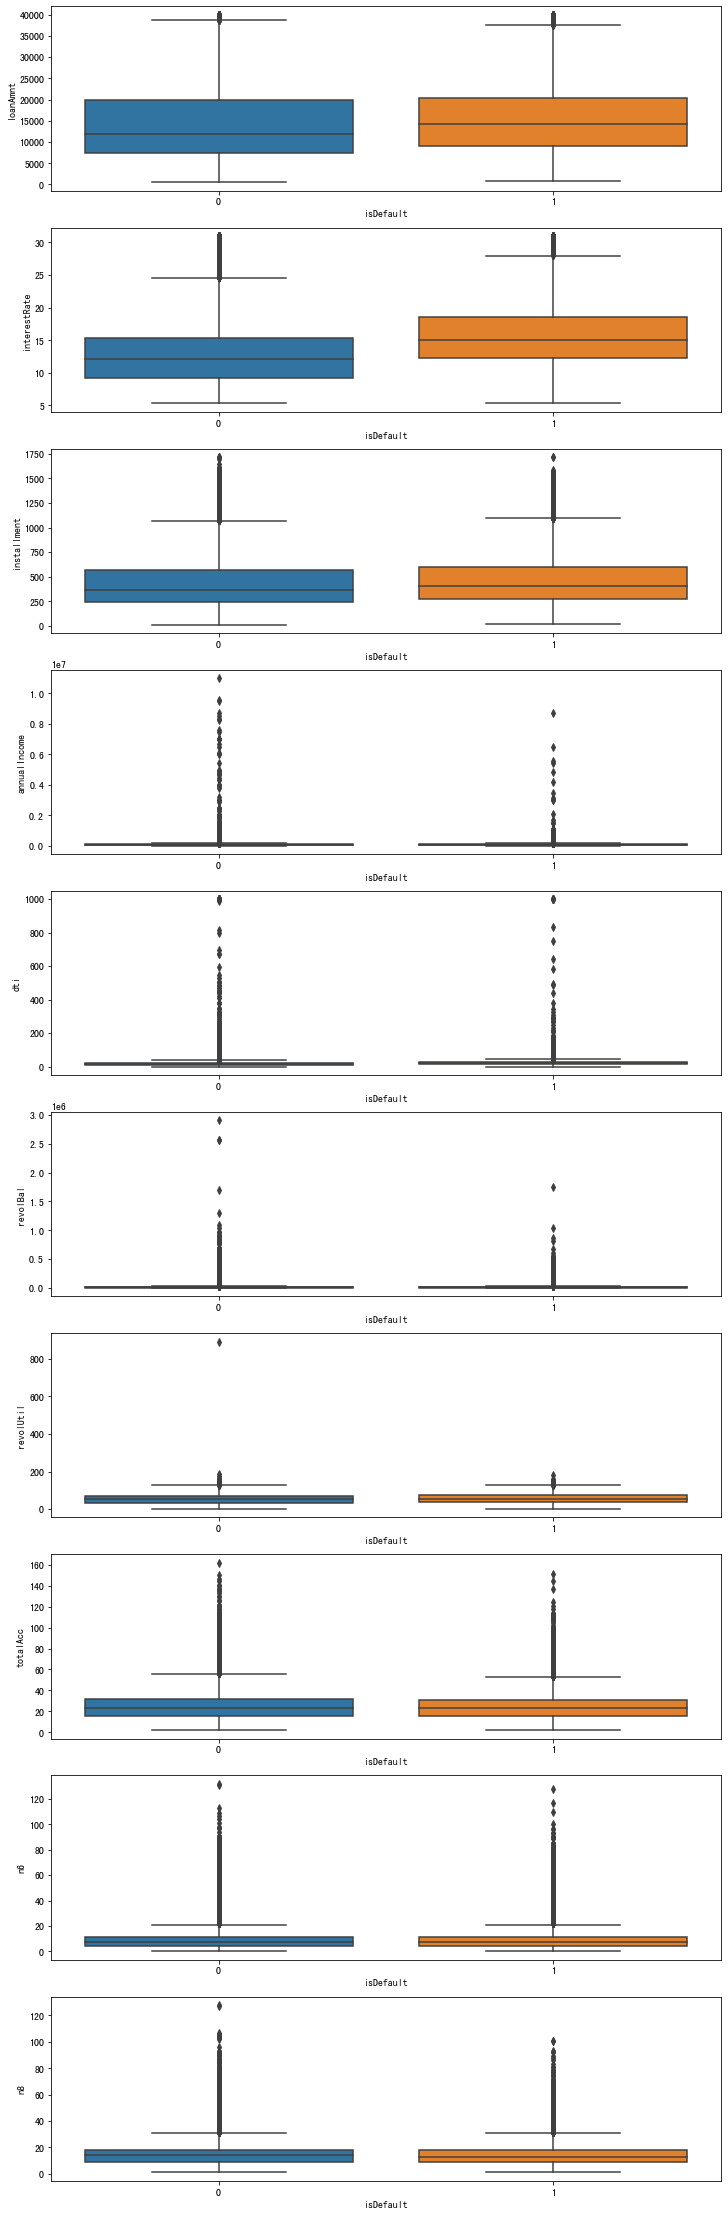

In [25]:
rows = len(anomaly_feas)
fig, axes = plt.subplots(nrows=rows, ncols=1, figsize=(12, 4*rows))
for i, fea in enumerate(anomaly_feas):
#     axes[i].set_title(fea)
    sns.boxplot(x="isDefault", y=fea, data=data_train, ax=axes[i])

### LOF

In [26]:
from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor(n_neighbors=2)
yhat = clf.fit_predict(data_train[anomaly_feas])

In [27]:
sum(yhat == -1)

124699

### 处理

结合 3sigma 和 LOF，取二者的并集删除样本。

In [28]:
data_train.shape, yhat.shape

((799997, 73), (799997,))

In [29]:
# 根据 LOF 删除异常值
lof_drop_index = []
for idx, yi in enumerate(yhat):
    if yi == -1:
        lof_drop_index.append(idx)

In [30]:
data_train = data_train.drop(lof_drop_index)

In [31]:
data_train.shape

(675298, 73)

In [32]:
# 根据 3sigma 删除异常值
for fea in anomaly_feas:
    data_train = data_train[data_train[fea+'_outliers']=='正常值']

In [33]:
data_train = data_train.reset_index(drop=True)

In [34]:
data_train.shape

(631315, 73)

In [35]:
need_drop_outlier_cols = [fea for fea in 
                          data_train.columns if "_outliers" in fea]

In [36]:
data_train = data_train.drop(columns=need_drop_outlier_cols)

In [37]:
data_train.shape

(631315, 63)

## 数据分箱

In [38]:
from optbinning import OptimalBinning

In [39]:
need_buckets_discret_feas

['employmentTitle', 'postCode', 'regionCode', 'title']

In [40]:
def categorical_binning(data: pd.DataFrame, fea: str, cat_cutoff: float):
    optb = OptimalBinning(name=fea, dtype="categorical", 
                      prebinning_method='quantile', 
                      solver="mip", cat_cutoff=cat_cutoff)
    optb.fit(data[fea], data["isDefault"])
    data[fea] = optb.transform(data[fea])
    return data

In [101]:
data_train = categorical_binning(data_train, "employmentTitle", 0.05)
data_train = categorical_binning(data_train, "postCode", 0.01)
data_train = categorical_binning(data_train, "regionCode", 0.1)
data_train = categorical_binning(data_train, "title", 0.1)

In [42]:
need_buckets_continous_feas = [
    'loanAmnt', 'interestRate', 'installment', 'annualIncome', 'dti', 'revolBal', 'revolUtil',
    'delinquency_2years', 'ficoRangeLow', 'ficoRangeHigh'
]

In [43]:
for fea in need_buckets_continous_feas:
    optb = OptimalBinning(name=fea, dtype="numerical", solver="cp")
    optb.fit(data_train[fea], data_train["isDefault"])
    data_train[fea] = optb.transform(data_train[fea])

## 特征交互

In [49]:
for col in ['grade', 'subGrade']: 
    temp_dict = data_train.groupby([col])['isDefault'].agg(['mean']).reset_index().rename(
        columns={'mean': col + '_target_mean'})
    temp_dict.index = temp_dict[col].values
    temp_dict = temp_dict[col + '_target_mean'].to_dict()

    data_train[col + '_target_mean'] = data_train[col].map(temp_dict)

In [51]:
for item in ['n0','n1','n2','n2.1','n4','n5','n6','n7','n8','n9','n10','n11','n12','n13','n14']:
    data_train['grade_to_mean_' + item] = \
        data_train['grade'] / data_train.groupby([item])['grade'].transform('mean')
    data_train['grade_to_std_' + item] = \
        data_train['grade'] / data_train.groupby([item])['grade'].transform('std')

## 特征筛选

In [160]:
data_train = data_train.replace([np.inf, -np.inf], np.nan)
data_train = data_train.dropna()

In [161]:
need_filter = []
donot_need_filter = []
for fea in data_train.columns:
    uiq = data_train[fea].nunique()
    if uiq == 1 or fea == "isDefault":
        continue
    elif 1 < uiq <= 4:
        donot_need_filter.append(fea)
    else:
        need_filter.append(fea)

In [162]:
data_train_filter = data_train[need_filter]

### 方差选择法

In [181]:
from sklearn.feature_selection import VarianceThreshold

In [ ]:
vt = VarianceThreshold(threshold=0.1)
X = vt.fit_transform(data_train, data_train.isDefault)

### 相关系数法

In [176]:
from sklearn.feature_selection import SelectKBest
from scipy.stats import pearsonr
sk = SelectKBest(k=5)
X = sk.fit_transform(data_train_filter, data_train.isDefault)

In [177]:
X.shape

(631294, 5)

### 卡方检验

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
#参数k为选择的特征个数

sk = SelectKBest(chi2, k=5)
X = sk.fit_transform(data_train_filter, data_train.isDefault)

### 互信息

In [ ]:
from sklearn.feature_selection import SelectKBest
from minepy import MINE

def mic(x, y):
    m = MINE()
    m.compute_score(x, y)
    return (m.mic(), 0.5)
sk = SelectKBest(
    lambda X, Y: array(map(lambda x:mic(x, Y), X.T)).T, k=2)
X = sk.fit_transform(data_train_filter, 
                     data_train.isDefault)

### RFE

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression


rfe = RFE(estimator=LogisticRegression(), 
          n_features_to_select=2)
X = rfe.fit_transform(data_train_filter, data_train.isDefault)

### 基于惩罚项

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

sf = SelectFromModel(
    LogisticRegression(penalty="l1", C=0.1)
)
X = sf.fit_transform(data_train_filter, data_train.isDefault)

### 基于树模型

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import GradientBoostingClassifier

sf = SelectFromModel(
    GradientBoostingClassifier())
X = sf.fit_transform(data_train_filter, data_train.isDefault)